In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mglearn  #> 학습 위해 만들어 놓은 패키지

import warnings
warnings.filterwarnings("ignore")

from matplotlib import rc, font_manager, rcParams
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc("font", family=font_name)
rcParams["axes.unicode_minus"] = False

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

C:\Users\acorn\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\acorn\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# 타이타닉 생존자 예측

    - https://www.kaggle.com/c/titanic/
    
    - 목표: 결과적으로 어떤 승객이 살아남았는가 판단

### 데이터 준비

In [78]:
train = pd.read_csv("data/titanic/train.csv")
test = pd.read_csv("data/titanic/test.csv")

In [79]:
train.head()
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [80]:
test.head()
test.info()
test.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### 탐색적 데이터 분석

    - 생존과 관련된 영향력 있는 변수 선정: Pclass, Sex, SibSp, Parch, Embarked, Cabin

In [81]:
def bar_chart(feature):
    survived = train[train["Survived"]==1][feature].value_counts()
    dead = train[train["Survived"]==0][feature].value_counts()
    df = pd.DataFrame([survived, dead])
    df.index = ["Survived", "Dead"]
    df.plot(kind="bar", stacked=True, figsize=(10, 5))

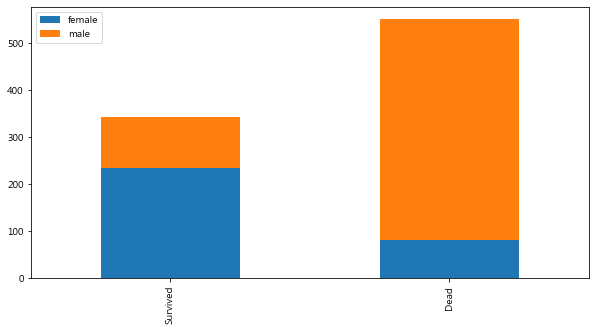

In [82]:
### 성별에 따른 차이

bar_chart("Sex")

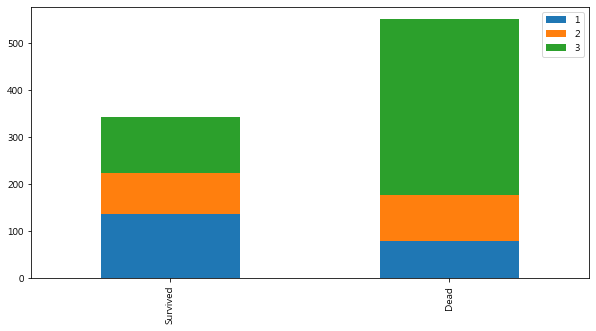

In [83]:
### 객실 등급에 따른 차이

bar_chart("Pclass")

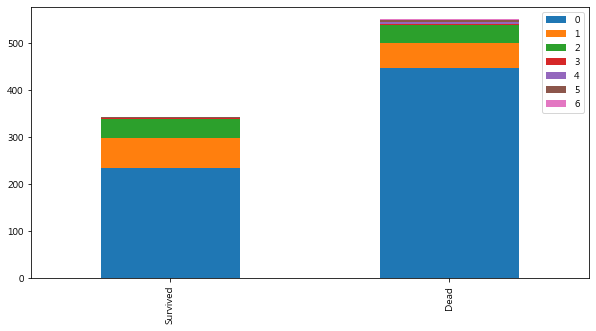

In [84]:
### 동승 여부(부모와 자식)에 따른 차이

bar_chart("Parch")

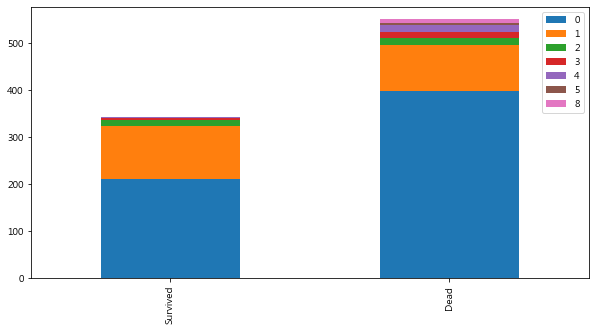

In [85]:
### 동승 여부(형제와 아내)에 따른 차이

bar_chart("SibSp")

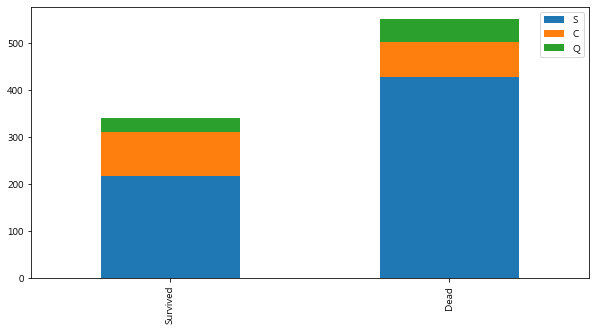

In [86]:
### 선착장에 따른 차이

bar_chart("Embarked")

### Feature Engineering

In [87]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [88]:
### Name 에 있는 호칭 선별

train_test_data = [train, test]  #> 묶어서 한번에 작업 위함

for dataset in train_test_data:
    dataset["Title"] = dataset["Name"].str.extract("([A-Za-z]+)\.")

In [89]:
train["Title"].value_counts()
test["Title"].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Dona        1
Ms          1
Dr          1
Name: Title, dtype: int64

In [90]:
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3,"Countess": 3, "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona" : 3, "Mme": 3,"Capt": 3,"Sir": 3 } 
for dataset in train_test_data: 
    dataset['Title'] = dataset['Title'].map(title_mapping)

In [91]:
train.head()
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,2
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,2


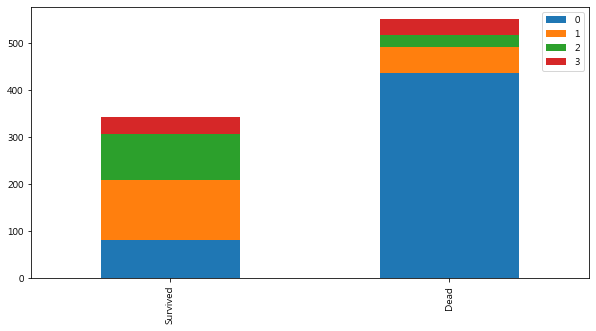

In [92]:
bar_chart("Title")

In [93]:
train.drop("Name", axis=1, inplace=True)
test.drop("Name", axis=1, inplace=True)

In [94]:
train.head()
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,female,47.0,1,0,363272,7.0000,NaN,S,2
2,894,2,male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,female,22.0,1,1,3101298,12.2875,NaN,S,2


In [95]:
### 성별의 숫자화

sex_mapping = {"male":0, "female":1}
for dataset in train_test_data:
    dataset["Sex"] = dataset["Sex"].map(sex_mapping)

In [96]:
train.head()
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,0,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,1,47.0,1,0,363272,7.0000,NaN,S,2
2,894,2,0,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,0,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,1,22.0,1,1,3101298,12.2875,NaN,S,2


In [97]:
### 나이에 대한 결측치 처리

train["Age"].fillna(train.groupby("Title")["Age"].transform("median"), inplace=True)
    #> 이상치 있거나 격차 너무 큰 경우 평균값보다 중앙값이 유리
test["Age"].fillna(test.groupby("Title")["Age"].transform("median"), inplace=True)

In [98]:
train.isnull().sum()
test.isnull().sum()

PassengerId      0
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Title            0
dtype: int64

In [99]:
# 나이 변수의 카테고리화(binning)
# child(16세 미만):0, young(16~26세):1, adult(26~36세):2, mid-age(36~62세):3, senior(62세 이상):4
for dataset in train_test_data:
    dataset.loc[dataset["Age"]<16, "Age"] = 0
    dataset.loc[(dataset["Age"]>=16)&(dataset["Age"]<26), "Age"] = 1
    dataset.loc[(dataset["Age"]>=26)&(dataset["Age"]<36), "Age"] = 2
    dataset.loc[(dataset["Age"]>=36)&(dataset["Age"]<62), "Age"] = 3
    dataset.loc[dataset["Age"]>=62, "Age"] = 4

In [100]:
train.head()
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,0,2.0,0,0,330911,7.8292,NaN,Q,0
1,893,3,1,3.0,1,0,363272,7.0000,NaN,S,2
2,894,2,0,4.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,0,2.0,0,0,315154,8.6625,NaN,S,0
4,896,3,1,1.0,1,1,3101298,12.2875,NaN,S,2


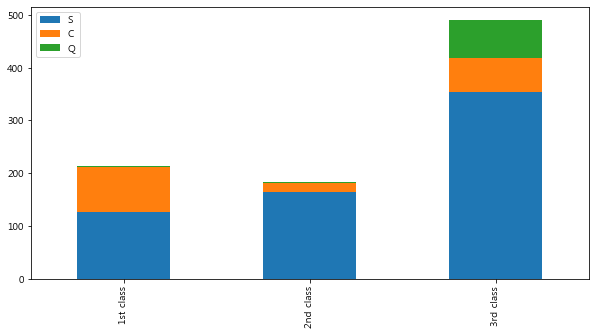

In [101]:
### Embarked 와 Pclass 상관관계 확인

train.isnull().sum()
test.isnull().sum()

p1 = train[train["Pclass"]==1]["Embarked"].value_counts()
p2 = train[train["Pclass"]==2]["Embarked"].value_counts()
p3 = train[train["Pclass"]==3]["Embarked"].value_counts()

df = pd.DataFrame([p1, p2, p3])
df.index = ["1st class", "2nd class", "3rd class"]
df.head()

df.plot(kind="bar", stacked=True, figsize=(10, 5))  #> 결측치 S선착장으로 대체해도 무관

In [102]:
# Embarked 결측치 S로 처리
train["Embarked"] = train["Embarked"].fillna("S")

In [103]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
Title            0
dtype: int64

In [104]:
# Embarked 값 숫자화
embarked_mapping = {"S":0, "C":1, "Q":2}
for dataset in train_test_data:
    dataset["Embarked"] = dataset["Embarked"].map(embarked_mapping)

In [105]:
train.head()
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,0,2.0,0,0,330911,7.8292,NaN,2,0
1,893,3,1,3.0,1,0,363272,7.0000,NaN,0,2
2,894,2,0,4.0,0,0,240276,9.6875,NaN,2,0
3,895,3,0,2.0,0,0,315154,8.6625,NaN,0,0
4,896,3,1,1.0,1,1,3101298,12.2875,NaN,0,2


In [106]:
### Fare의 범주회

# Pclass 이용하여 test 샘플의 Fare 결측치 채움
train["Fare"].isnull().sum()
test["Fare"].isnull().sum()  #> 결측치 1개 발견

test["Fare"].fillna(test.groupby("Pclass")["Fare"].transform("median"), inplace=True)

test["Fare"].isnull().sum()

0

In [107]:
for dataset in train_test_data:
    dataset.loc[dataset["Fare"]<=17, "Fare"] = 0
    dataset.loc[(dataset["Fare"]>17)&(dataset["Fare"]<=30), "Fare"] = 1
    dataset.loc[(dataset["Fare"]>30)&(dataset["Fare"]<=100), "Fare"] = 2
    dataset.loc[dataset["Fare"]>100, "Fare"] = 3

In [108]:
train.head()
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,0,2.0,0,0,330911,0.0,NaN,2,0
1,893,3,1,3.0,1,0,363272,0.0,NaN,0,2
2,894,2,0,4.0,0,0,240276,0.0,NaN,2,0
3,895,3,0,2.0,0,0,315154,0.0,NaN,0,0
4,896,3,1,1.0,1,1,3101298,0.0,NaN,0,2


In [109]:
### Cabin(방 번호)의 결측치 처리

train["Cabin"].value_counts()

C23 C25 C27        4
G6                 4
B96 B98            4
D                  3
C22 C26            3
F33                3
E101               3
F2                 3
B20                2
C52                2
C126               2
C124               2
B22                2
B5                 2
D36                2
E24                2
C93                2
E33                2
E121               2
D17                2
E8                 2
C92                2
B51 B53 B55        2
B18                2
F4                 2
C78                2
C125               2
E67                2
D35                2
B57 B59 B63 B66    2
                  ..
D21                1
B94                1
E40                1
B50                1
A14                1
T                  1
C47                1
E50                1
B82 B84            1
C111               1
D30                1
D7                 1
C95                1
B73                1
A16                1
D45                1
A10          

In [110]:
for dataset in train_test_data:
    dataset["Cabin"] = dataset["Cabin"].str[:1]

In [111]:
train.Cabin.value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin, dtype: int64

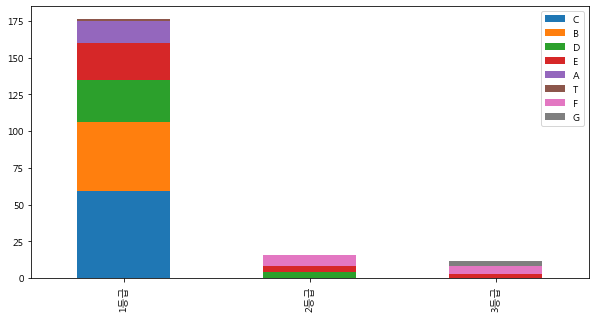

In [112]:
p1 = train[train["Pclass"]==1]["Cabin"].value_counts()
p2 = train[train["Pclass"]==2]["Cabin"].value_counts()
p3 = train[train["Pclass"]==3]["Cabin"].value_counts()

df = pd.DataFrame([p1, p2, p3])
df.index = ["1등급", "2등급", "3등급"]
df.plot(kind="bar", stacked=True, figsize=(10, 5))

In [113]:
cabin_mapping = {"A":0, "B":0.4, "C":0.8, "D":1.2, "E":1.6, "F":2, "G":2.4, "T":2.8}

for dataset in train_test_data:
    dataset["Cabin"] = dataset["Cabin"].map(cabin_mapping)

In [114]:
train["Cabin"].fillna(train.groupby("Pclass")["Cabin"].transform("median"), inplace=True)
test["Cabin"].fillna(test.groupby("Pclass")["Cabin"].transform("median"), inplace=True)

In [115]:
train.head()
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,0,2.0,0,0,330911,0.0,2.0,2,0
1,893,3,1,3.0,1,0,363272,0.0,2.0,0,2
2,894,2,0,4.0,0,0,240276,0.0,2.0,2,0
3,895,3,0,2.0,0,0,315154,0.0,2.0,0,0
4,896,3,1,1.0,1,1,3101298,0.0,2.0,0,2


In [116]:
### 동승자 유무에 따른 파생변수 생성(동승자 컬럼 결합)

train["Family"] = train["SibSp"] + train["Parch"] + 1
test["Family"] = test["SibSp"] + test["Parch"] + 1

In [117]:
train["Family"].value_counts()
test["Family"].value_counts()

1     253
2      74
3      57
4      14
5       7
11      4
7       4
6       3
8       2
Name: Family, dtype: int64

In [118]:
family_mapping = {1:0, 2:0.4, 3:0.8, 4:1.2, 5:1.6, 6:2, 7:2.4, 8:2.8, 9:3.2, 10:3.6, 11:4}

for dataset in train_test_data:
    dataset["Family"] = dataset["Family"].map(family_mapping)

In [119]:
train.head()
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family
0,892,3,0,2.0,0,0,330911,0.0,2.0,2,0,0.0
1,893,3,1,3.0,1,0,363272,0.0,2.0,0,2,0.4
2,894,2,0,4.0,0,0,240276,0.0,2.0,2,0,0.0
3,895,3,0,2.0,0,0,315154,0.0,2.0,0,0,0.0
4,896,3,1,1.0,1,1,3101298,0.0,2.0,0,2,0.8


In [120]:
features_drop = ["Ticket", "SibSp", "Parch"]

train = train.drop(features_drop, axis=1)
test = test.drop(features_drop, axis=1)

In [164]:
train = train.drop("PassengerId", axis=1)

train.head()
test.head()

KeyError: "['PassengerId'] not found in axis"

In [165]:
train_data = train.drop("Survived", axis=1)
target = train["Survived"]

In [166]:
print(train_data.shape, target.shape)

(891, 8) (891,)


### Modeling
    - KNN
    - Decision Tree
    - Random Forest
    - SVM
    - Naive Bayes

In [167]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [168]:
### Cross Validation(K-fold): 테스트 전 훈련 데이터로 미리 적합도 검증(알고리즘 선택)

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [169]:
# KNN
clf = KNeighborsClassifier(n_neighbors=13)
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring="accuracy")
print(score)

round(np.mean(score)*100, 2)

[0.77777778 0.73033708 0.82022472 0.83146067 0.83146067 0.82022472
 0.78651685 0.79775281 0.79775281 0.79775281]


79.91

In [170]:
# Decision Tree
clf = DecisionTreeClassifier()
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring="accuracy")
print(score)

round(np.mean(score)*100, 2)

[0.78888889 0.88764045 0.76404494 0.78651685 0.87640449 0.79775281
 0.79775281 0.79775281 0.74157303 0.80898876]


80.47

In [171]:
# RandomForest
clf = RandomForestClassifier(n_estimators=13)
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring="accuracy")
print(score)

round(np.mean(score)*100, 2)

[0.82222222 0.87640449 0.80898876 0.82022472 0.88764045 0.82022472
 0.82022472 0.7752809  0.7752809  0.80898876]


82.15

In [172]:
# Naive Bayes
clf = GaussianNB()
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring="accuracy")
print(score)

round(np.mean(score)*100, 2)

[0.85555556 0.73033708 0.75280899 0.75280899 0.70786517 0.80898876
 0.76404494 0.80898876 0.86516854 0.83146067]


78.78

In [173]:
# Support Vector Machine: 가장 나은 성능 보인다
clf = SVC()
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring="accuracy")
print(score)

round(np.mean(score)*100, 2)

[0.83333333 0.80898876 0.83146067 0.82022472 0.84269663 0.82022472
 0.84269663 0.85393258 0.82022472 0.85393258]


83.28

### Testing: SVC를 이용하여 테스트

In [174]:
clf = SVC()
clf.fit(train_data, target)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [175]:
test.head()
test_data = test.drop("PassengerId", axis=1).copy()  #> test 원본 보호

In [176]:
train_data.head()

,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Family
0,3,0,1.0,0.0,2.0,0,0,0.4
1,1,1,3.0,2.0,0.8,1,2,0.4
2,3,1,2.0,0.0,2.0,0,1,0.0
3,1,1,2.0,2.0,0.8,0,2,0.4
4,3,0,2.0,0.0,2.0,0,0,0.0


In [177]:
test_data.head()

,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Family
0,3,0,2.0,0.0,2.0,2,0,0.0
1,3,1,3.0,0.0,2.0,0,2,0.4
2,2,0,4.0,0.0,2.0,2,0,0.0
3,3,0,2.0,0.0,2.0,0,0,0.0
4,3,1,1.0,0.0,2.0,0,2,0.8


In [178]:
prediction = clf.predict(test_data)

In [179]:
submission = pd.DataFrame({"PannengerId":test["PassengerId"], "Survived":prediction})
submission.head

<bound method NDFrame.head of      PannengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
5            897         0
6            898         1
7            899         0
8            900         1
9            901         0
10           902         0
11           903         0
12           904         1
13           905         0
14           906         1
15           907         1
16           908         0
17           909         0
18           910         1
19           911         1
20           912         0
21           913         1
22           914         1
23           915         0
24           916         1
25           917         0
26           918         1
27           919         0
28           920         0
29           921         0
..           ...       ...
388         1280         0
389         1281         0
390         1282         0
391         1283         

In [180]:
submission.to_csv("data/titanic/submission.csv", index=False)